# Temporal Difference Learning

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

## Bellman's Equation

$$
v_\pi (s) = \sum_a \pi (a | s) \left[ \sum_{s'} p (s' | s,a) \left[ r(s',s,a) + \gamma v_\pi (s') \right]  \right]
$$
$$
\vec{v} = T \left( \vec{\pi} \odot \left[ (P \odot R) \vec{1} + \gamma P \vec{v} \right] \right)
$$

# MDP Class

In [3]:
class MDP():
    
    def __init__(self, P, R, terminal=[], Pi=None, gamma=0.9):
        '''
         MDP(P, R, Pi=None, gamma=0.9)
         
         P  is an n_states x n_actions x n_states array
         R  is an n_states x n_actions array
         terminal is a list of terminal states
         Pi is an n_states x n_actions array
         gamma is the temporal discount factor
        '''
        self.n_states, self.n_actions, _ = np.shape(P)
        self.P = P                      # State transition function
        self.R = R                      # Reward function
        self.terminal = terminal        # Terminal states
        self.gamma = gamma              # Temporal discount factor
        if Pi!=None:
            self.Pi = Pi                # Policy function
        else:
            self.Pi = np.ones((self.n_states, self.n_actions)) / self.n_actions
        
        self.v = np.zeros(self.n_states)                    # Value function
        self.Q = np.zeros((self.n_states, self.n_actions))  # Q function
        self.E = np.zeros((self.n_states, self.n_actions))  # Elegibility function
        
        self.M = np.zeros((self.n_states, self.n_actions, 3)) # State transition model (for model-based RL)
        # M[s,a,0] is the anticipated reward
        # M[s,a,1] is the anticipated new state
        # M[s,a,2] is 1 if (s,a) was experienced, otherwise 0
        
        self.b = []  # Used for full policy evaluation
        self.B = []  # "
        self.state = 0       # Current state

    def AddTerminalState(self, t):
        self.terminal.append(t)
        
    def Step(self, action=None):
        '''
         mdp.Step(action=None)
         
         Take a step by choosing an action.
         
         Inputs:
           action is the index of the action to choose.
                  If None, then it chooses an action according to the policy.
        '''
        if action is None:
            action = self.SampleAction()
        
        # New state
        newstate_idx = self.sample(self.P[self.state, action, :])
        reward = self.R[self.state, action]
        
        # Is this a terminal state?
        done = 0
        if newstate_idx in(self.terminal):
            #if np.max(self.P[newstate_idx, :, newstate_idx]) == 1.:
            done = 1
        return self.state, action, reward, newstate_idx, done
    
    def sample(self, p):
        '''
         idx = mdp.sample(p)
         
         Randomly choose an index according to the probability vector p.
         
         Input:
           p  is a probability vector
           
         Output:
           idx is an index of the vector p
        '''
        c = copy.deepcopy(p)
        for k in range(1,len(c)):
            c[k] += c[k-1]
        r = np.random.rand()
        result = np.where(r>c)
        return len(result[0])
    
    def SampleAction(self, state=None, Pi=None, eps=0.):
        '''
         a = mdp.SampleAction(state=None)
         
         Choose an action.
         
         Input:
           state is the state to choose an action from.
                 If None, then use mdp.state.
           Pi is the policy. If None, then use mdp.Pi.
           eps is the epsilon to use for epsilon-greedy action selection.
        '''
        if state is None:
            state = self.state
        if Pi is None:
            Pi = self.Pi
        Pi_eps = copy.deepcopy(Pi)
        Pi_eps += eps
        for pi_row in Pi_eps:
            pi_row /= np.sum(pi_row)
        return self.sample(Pi_eps[state,:])
        
    def LinearSystem(self, Pi=None, R=None, P=None, gamma=None):
        list_like = (np.ndarray,)
        if not isinstance(Pi, list_like):
            Pi = self.Pi
        if not isinstance(P, list_like):
            P = self.P
        if not isinstance(R, list_like):
            R = self.R
        if gamma==None:
            gamma = self.gamma
        self.b = np.sum( Pi * R, axis=1 )
        self.B = gamma * np.sum(Pi[:,:,np.newaxis]*P, axis=1)

    def EvaluatePolicy(self):
        self.LinearSystem()
        #B = self.gamma * np.einsum('ijk,ijk->ik', self.Pi[:,:,np.newaxis], self.P)
        v = np.linalg.solve(np.eye(self.n_states)-self.B, self.b)
        self.v = v
        return v

    def EvaluateStep(self, n_steps=100, tol=1.e-4):
        '''
         EvaluateStep(n_steps=100, tol=1.e-4)
         
         Iteratively maps the current value vector using the Bellman equation.
         The iterations stop when
           - it reaches n_steps, or
           - if max(abs(v-vnew))<tol,
         whichever comes first.
        '''
        self.LinearSystem()
        delta_V = 1.e50
        k = 0
        while delta_V>=tol and k<n_steps:
            v_copy = copy.deepcopy(self.v)
            self.v = self.B @ v_copy + self.b
            k += 1
            delta_V = np.max(np.abs(self.v-v_copy))
        #print(str(k)+' steps')
        return self.v

    def ValueIteration(self, n_steps=100, tol=1.e-4):
        '''
         Pi = mdp.ValueIteration(n_steps=100, tol=1.e-4)
         
         Performs value iteration, starting from the current value vector.
         The iterations stop when
           - it reaches n_steps, or
           - if max(abs(v-vnew))<tol,
         whichever comes first.
        '''
        delta_V = 1.e50
        k = 0
        while delta_V>=tol and k<n_steps:
            v_copy = copy.deepcopy(self.v)
            self.LinearSystem()
            v_new = np.zeros_like(self.R)
            for a in range(n_actions):
                v_new[:,a] = self.B@self.v + self.b
            self.v = np.max(v_new, axis=1)
            delta_V = np.max(np.abs(self.v - v_copy))
            k += 1
        
        return self.OptimalPolicy()
        
    def PolicyIteration(self):
        '''
         Pi = mdp.PolicyIteration()
         
         Performs policy iteration, starting from the current value vector.
         The iteration stops when the policy does not change in an iteration.
        '''
        delta_Pi = 1.
        Pi_copy = copy.deepcopy(self.Pi)
        while delta_Pi!=0:
            self.EvaluateStep(n_steps=1)
            Pi_new = self.OptimalPolicy()
            delta_Pi = np.max(np.abs(Pi_copy - Pi_new))
            Pi_copy = copy.deepcopy(Pi_new)
            
        return Pi_new
        
    def OptimalPolicyFromQ(self):
        '''
         Pi = mdp.OptimalPolicyFromQ()
         
         Returns the optimal policy from the current Q function.
        '''
        Pi_opt = np.zeros_like(self.Pi)
        for s in range(self.n_states):
            q_star = np.max(self.Q[s,:])
            blah = self.Q[s,:]==q_star
            Pi_opt[s,:] = blah / np.sum(blah)
            
        return Pi_opt
        
    def OptimalPolicy(self):
        '''
         Pi = mdp.OptimalPolicy()

         Returns the optimal policy for the current value function.
        '''
        if len(self.v)==0:
            self.v = np.zeros(self.n_states)

        v_new = np.zeros((self.n_states,self.n_actions), dtype=float)
        for a in range(self.n_actions):
            Pi_a = np.zeros_like(self.Pi)
            Pi_a[:,a] = 1.

            self.LinearSystem(Pi=Pi_a)
            v_new[:,a] = self.B@self.v + self.b

        Pi_opt = np.zeros_like(self.Pi)
        for s in range(self.n_states):
            a_star = np.max(v_new[s,:])
            blah = v_new[s,:]==a_star
            Pi_opt[s,:] = blah / np.sum(blah)
            
        return Pi_opt

            
    def Episode(self):
        '''
         trajectory = mdp.Episode()
         
         Creates a trajectory that starts at the current state and follows the optimal policy.
         
         Output:
           trajectory is a list of states
        '''
        max_iters = 100
        done = 0
        n_iters = 0
        s = self.state
        traj = [s]
        while not done and n_iters<max_iters:
            oldstate, action, reward, newstate, done = self.Step()
            traj.append(newstate)
            self.state = newstate
            n_iters += 1
            
        return traj
    
    
    def SARSA_lambda(self, alpha=0.1, eps=0.1, lam=0.9, trace='dutch'):
        '''
         mdp.SARSA_lambda(alpha=0.1, eps=0.1, lam=0.9, trace='dutch')
         
         Performs an episode using SARSA(lambda).
         The method uses eligibility traces with decay lam.
         It uses the current state, and updates mdp.Q and mdp.E.
         
         Inputs:
           alpha  TD learning rate
           eps    epsilon used for epsilon-greedy action selection
           lam    trace decay
           trace  type of eligibility increment, one of:
                   'dutch', 'accumulating', or 'replacing'
        '''
        iters_max = 100
        # Current state is in self.state
        # Choose an action using policy
        A = self.SampleAction(Pi=self.OptimalPolicyFromQ(), eps=eps)
        # for each step of an episode
        done = 0
        n_iters = 0
        traj = [self.state]
        self.E[:,:] = 0.
        while not done and n_iters<iters_max:
            # Take action, get reward and newstate
            oldstate, action, reward, newstate, done = self.Step(action=A)
            # Choose newaction from newstate
            newaction = self.SampleAction(state=newstate, Pi=self.OptimalPolicyFromQ(), eps=eps)
            
            # Compute the return delta
            delta = reward + self.gamma*self.Q[newstate,newaction] - self.Q[self.state,A]
            
            # Increment self.E for current state/action
            if trace=='dutch':
                self.E[self.state,A] += 1. - alpha*self.E[self.state,A]   # Dutch trace
            elif trace=='accumulating':
                self.E[self.state,A] += 1.                                # Accumulating trace
            else:
                self.E[self.state,A] = 1.                                 # Replacing trace
            
            for s in range(self.n_states):
                for a in range(self.n_actions):
                    # Update self.Q
                    self.Q[s,a] += alpha*delta*self.E[s,a]
                    
                    # Update self.E
                    self.E[s,a] *= self.gamma*lam
                    
            # Switch state to newstate, and action to newaction
            self.state = newstate
            traj.append(newstate)
            A = newaction
            n_iters += 1
        
        return traj
        
        
    def SARSA(self, alpha=0.1, eps=0.1):
        '''
         mdp.SARSA(alpha=0.1, eps=0.1)
         
         Performs an episode using SARSA, updating mdp.Q as it goes.
         It uses the current state.
        '''
        iters_max = 100
        # Current state is in self.state
        # Choose an action using policy
        a = self.SampleAction(Pi=self.OptimalPolicyFromQ(), eps=eps)
        # for each step of an episode
        done = 0
        n_iters = 0
        while not done and n_iters<iters_max:
            # Take action, get reward and newstate
            oldstate, action, reward, newstate, done = self.Step(action=a)
            # Choose newaction from newstate
            newaction = self.SampleAction(state=newstate, Pi=self.OptimalPolicyFromQ(), eps=eps)
            
            # Update self.Q
            self.Q[self.state, a] = (1-alpha)*self.Q[self.state,a] + alpha*( reward + self.gamma*self.Q[newstate,newaction] )
            # Switch state to newstate, and action to newaction
            self.state = newstate
            a = newaction
            n_iters += 1

            
    def DynaQ(self, alpha=0.1, eps=0.1, n=5):
        '''
         traj = mdp.DynaQ(alpha=0.1, eps=0.1, n=5)
         
         Performs an episode of Dyna-Q model-based Q-learning.
         Starting from the current state, it takes n planning steps for each
         actual step. It updates mdp.Q and mdp.M, and returns the trajectory.
        '''
        done = 0
        iters_max = 100
        n_iters = 0
        traj = [self.state]
        while not done and n_iters<iters_max:
            # Choose an action using policy
            A = self.SampleAction(Pi=self.OptimalPolicyFromQ(), eps=eps)
            
            # Take action, get reward and newstate
            oldstate, action, reward, newstate, done = self.Step(action=A)
            
            # Update self.Q
            maxQ = np.max(self.Q[newstate,:])
            self.Q[self.state,A] = (1-alpha)*self.Q[self.state,A] + alpha*( reward + self.gamma*maxQ )
            
            traj.append(newstate)
            
            # n planning steps
            for nn in range(n):
                s,a = self.ChoosePreviousExperience()
                if s is not None:
                    R = self.M[s,a,0]
                    planningstate = self.M[s,a,1]
                    maxQ = np.max(self.Q[planningstate,:])
                    self.Q[s,a] += alpha * ( R + self.gamma*maxQ - self.Q[s,a] )
            
            # Switch state to newstate
            self.state = newstate
            n_iters += 1
            
    def ChoosePreviousExperience(self):
        '''
         s,a = mdp.ChoosePreviousExperience()
         
         Returns a state/action pair that has been done before, based on the
         model stored in mdp.M.
        '''
        r,c = np.nonzero(self.M[:,:,2])
        coords = list(zip(r,c))
        if len(coords)>0:
            idx = np.random.randint(0,len(coords))
            return coords[idx]
        else:
            return None, None
            
    def QLearning(self, alpha=0.1, eps=0.1):
        iters_max = 100
        # Current state is in self.state
        # for each step of an episode
        done = 0
        n_iters = 0
        while not done and n_iters<iters_max:
            
            # Choose an action using policy
            a = self.SampleAction(Pi=self.OptimalPolicyFromQ(), eps=eps)
            
            # Take action, get reward and newstate
            oldstate, action, reward, newstate, done = self.Step(action=a)
            
            # Update self.Q
            maxQ = np.max(self.Q[newstate,:])
            self.Q[self.state, a] = (1-alpha)*self.Q[self.state,a] + alpha*( reward + self.gamma*maxQ )
            
            # Switch state to newstate, and action to newaction
            self.state = newstate
            n_iters += 1

In [4]:
M = np.zeros((5,5,2), dtype=np.float32)

In [5]:
M[2,2,1] = 1.
M[1,2,1] = 1.
M[3,1,1] = 1.

In [6]:
r,c = np.nonzero(M[:,:,1])
coords = list(zip(r,c))
print(coords)
idx = np.random.randint(len(coords))
print(coords[idx])

[(1, 2), (2, 2), (3, 1)]
(2, 2)


In [7]:
for coord in zip(r,c):
    print(coord)

(1, 2)
(2, 2)
(3, 1)


## 1D GridWorld

### Create arrays

In [8]:
gs = 8  # grid length
n_actions = 2  # number of actions
golden_square_idx = 4
golden_square_reward = 4.
terminal = [golden_square_idx]
movement_cost = -0.5

In [9]:
Pi = np.ones((gs,n_actions)) / n_actions
print(Pi)

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


In [10]:
# State Transition Probabilities: 1D Grid
# P[s,a,t] is the probability of action a taking you from state s to state t
# P[s,a,t] = p(t|a,s)
P = np.zeros((gs,n_actions,gs))
P[0,0,0] = 1.  # Given: action 'decrease' and state 0, prob of ending in state 0
P[0,1,1] = 1.
for l in range(1,gs-1):
    if l==golden_square_idx:
        # 'decrease' takes you to 0, 'increase' takes you to last
        P[l,0,0] = 1.
        P[l,1,-1] = 1.
    else:
        P[l,0,l-1] = 1.
        P[l,1,l+1] = 1.
P[-1,1,-1] = 1.
P[-1,0,-2] = 1.

print(P)

[[[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]]]


In [11]:
# Reward Function: 1D Grid
# R[s,a] is the reward of taking action a from state s to state t
# R[s,a] = r(s,a)
R = np.zeros((gs,n_actions))
R[0,0] = -2.   # Penalty for trying to go off the grid
R[0,1] = movement_cost
R[-1,1] = -2.  # Penalty for trying to go off the grid
R[-1,0] = movement_cost
for l in range(1,gs-1):
    # Reward (cost) of a normal movement
    R[l,0] = movement_cost
    R[l,1] = movement_cost
R[golden_square_idx-1,1] = golden_square_reward
R[golden_square_idx+1,0] = golden_square_reward
R[golden_square_idx,:] = 0.

print(R)

[[-2.  -0.5]
 [-0.5 -0.5]
 [-0.5 -0.5]
 [-0.5  4. ]
 [ 0.   0. ]
 [ 4.  -0.5]
 [-0.5 -0.5]
 [-0.5 -2. ]]


### Create Markov Decision Process object

In [12]:
gw = MDP(P, R, terminal=terminal)

### Find optimal policy

In [13]:
oldstate, action, reward, newstate, done = gw.Step()
print('old state: '+str(oldstate))
print('   action: '+str(action))
print('   reward: '+str(reward))
print('new state: '+str(newstate))
print('     done: '+str(done))
gw.state = newstate

old state: 0
   action: 0
   reward: -2.0
new state: 0
     done: 0


In [14]:
gw.ValueIteration()

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [15]:
gw.EvaluatePolicy()

array([-6.60280705, -5.29231973, -4.04679234, -2.58944104, -5.59640996,
       -2.72689723, -4.35225054, -5.83365954])

In [16]:
gw.Pi = gw.PolicyIteration()

In [17]:
gw.EvaluatePolicy()

array([5.49302123, 6.65891247, 7.95434719, 9.3937191 , 5.99302123,
       9.3937191 , 7.95434719, 6.65891247])

### SARSA

In [18]:
for n_episodes in range(500):
    gw.state = np.random.randint(0,gw.n_states)
    #gw.state = np.random.choice([0,gw.n_states-1])
    gw.SARSA(alpha=0.1, eps=0.25)

In [19]:
print(gw.Q)

[[-1.37361181  1.26902046]
 [-0.01096624  2.81836005]
 [ 1.26559583  3.50690555]
 [ 2.2033877   5.01520762]
 [ 0.23777703  1.52556548]
 [ 5.09877781  2.027761  ]
 [ 3.61268523  1.30850712]
 [ 2.65205939 -0.51865569]]


In [20]:
gw.Pi = gw.OptimalPolicyFromQ()
print(gw.Pi)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


### Q-Learning

In [21]:
for n_episodes in range(50):
    gw.state = np.random.randint(0,gw.n_states)
    #gw.state = np.random.choice([0,gw.n_states-1])
    gw.QLearning(alpha=0.1, eps=0.25)

In [22]:
gw.Pi = gw.OptimalPolicyFromQ()
print(gw.Pi)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


## 2D Gridworld

### Define the 2D MDP class

In [513]:
class MDP_2d(MDP):
    def __init__(self, P, R, side=5, terminal=[], Pi=None, gamma=0.9):
        '''
         MDP(P, R, terminal=[], Pi=None, gamma=0.9)
         
         P  is an n_states x n_actions x n_states array
         R  is an n_states x n_actions array
         side is the length of the side of the arena
         terminal is a list of coords for terminal states
         Pi is an n_states x n_actions array
        '''
        terminal_idx = []
        for t in terminal:
            terminal_idx.append(coord2idx(t, side))
        MDP.__init__(self, P,R,terminal=terminal_idx,Pi=Pi,gamma=gamma)
        self.side = side
        
    def ShowValue(self):
        print( np.round( np.reshape(self.v, (self.side,self.side)), 1) )
    
    def ShowPolicy(self):
        for a in range(self.n_actions):
            print('Action '+str(a))
            print(np.reshape(self.Pi[:,a], (self.side,self.side)))

    def ShowFunction(self, M):
        '''
         mdp2.ShowFunction(M)
         
         Displays the (state,action) function M, showing the spatial 2D M for
         for one action at a time.
        '''
        for a in range(self.n_actions):
            print('Action '+str(a))
            print(np.round(np.reshape(M[:,a], (self.side,self.side)), 3))
        
    def ShowQ(self):
        for a in range(self.n_actions):
            print('Action '+str(a))
            print(np.round(np.reshape(self.Q[:,a], (self.side,self.side)), 3))
            
    def ShowR(self):
        for a in range(self.n_actions):
            print('Action '+str(a))
            print(np.round(np.reshape(self.R[:,a], (self.side,self.side)), 3))
        
    def PlotTrajectory(self, traj, fig=None):
        tcoords = []
        for t in traj:
            tcoords.append(idx2coord(t, self.side))
        tcoords = np.array(tcoords)
        if fig is None:
            fig = plt.figure(figsize=(8,8))
        plt.axis([-1,self.side,-1,self.side])
        plt.plot(tcoords[:,1], tcoords[:,0], 'o--')
        plt.grid(True)
        return fig

### Set up the matrices

In [99]:
gl = 5  # grid length
gs = gl*gl
n_actions = 4  # number of actions
A_coords = (0,1)
A_reward = 10.
Ap_coords = (4,1)
B_coords = (0,3)
B_reward = 5
Bp_coords = (2,3)
C_coords = (2,2)
C_reward = 2
terminal = [A_coords, B_coords]
movement_cost = 0.

In [100]:
def coord2idx(coords, row_length):
    return coords[0]*row_length + coords[1]
def idx2coord(idx, row_length):
    row = idx//row_length
    col = idx%row_length
    return (row,col)

In [101]:
# State Transition Probabilities: 2D Grid
# P[s,a,t] is the probability of action a taking you from state s to state t
# P[s,a,t] = p(t|a,s)
# 0==up, 1==right, 2==down, 3==left
P = np.zeros((gs,n_actions,gs))
for sr in range(gl):
    sr_offset = sr*gl
    for sc in range(gl):
        #idx = sr_offset + sc
        idx = coord2idx([sr,sc], gl)
        for a in range(4):
            img = np.zeros((gl,gl))
            if sr==A_coords[0] and sc==A_coords[1]:   # A, any action
                img[Ap_coords[0],Ap_coords[1]] = 1.
            elif sr==B_coords[0] and sc==B_coords[1]: # B, any action
                img[Bp_coords[0],Bp_coords[1]] = 1.
            elif sr==0 and a==0:    # top row, up
                img[sr,sc] = 1.
            elif sr==gl-1 and a==2: # bottom row, down
                img[sr,sc] = 1.
            elif sc==0 and a==3:    # left col, left
                img[sr,sc] = 1.
            elif sc==gl-1 and a==1: # right col, right
                img[sr,sc] = 1.
            elif a==0:              # up
                img[sr-1,sc] = 1.
            elif a==1:              # right
                img[sr,sc+1] = 1.
            elif a==2:              # down
                img[sr+1,sc] = 1.
            elif a==3:              # left
                img[sr,sc-1] = 1.
            P[idx,a,:] = img.flatten()

In [102]:
# Reward Function: 2D Grid
# R[s,a] is the reward of taking action a from state s to state t
# R[s,a] = r(s,a)
R = np.zeros((gs,n_actions))
for sr in range(gl):
    sr_offset = sr*gl
    for sc in range(gl):
        #idx = sr_offset + sc
        idx = coord2idx([sr,sc], gl)
        #svec = np.zeros(gs)
        #svec[idx] = 1.
        for a in range(4):
            reward = 0.
            tvec = P[idx,a,:]
            tidx = np.argmax(tvec)
            tcoords = idx2coord(tidx, gl)
            if tcoords==A_coords:
                reward += A_reward
            elif tcoords==B_coords:
                reward += B_reward
            elif tcoords==C_coords:
                reward += C_reward
            elif sr==0 and a==0:    # top row, up
                reward += -1.
            elif sr==gl-1 and a==2: # bottom row, down
                reward += -1.
            elif sc==0 and a==3:    # left col, left
                reward += -1.
            elif sc==gl-1 and a==1: # right col, right
                reward += -1.
            R[idx,a] = reward

### Create MDP

In [122]:
grid2d = MDP_2d(P, R, side=5, terminal=terminal)

In [111]:
grid2d.ShowR()

Action 0
[[-1. -1. -1. -1. -1.]
 [ 0. 10.  0.  5.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Action 1
[[10.  0.  5.  0. -1.]
 [ 0.  0.  0.  0. -1.]
 [ 0.  2.  0.  0. -1.]
 [ 0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0. -1.]]
Action 2
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1.]]
Action 3
[[-1.  0. 10.  0.  5.]
 [-1.  0.  0.  0.  0.]
 [-1.  0.  0.  2.  0.]
 [-1.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.]]


### Find optimal policy

In [24]:
grid2d.ShowValue()

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [25]:
grid2d.EvaluatePolicy()

array([ 3.80734393, -1.40504816,  4.89235522,  0.18039256,  1.72683283,
        1.82299998,  3.36666558,  2.52054581,  2.124479  ,  0.70742102,
        0.21632375,  0.9133494 ,  0.818926  ,  0.47821396, -0.30352832,
       -0.88012313, -0.34258469, -0.27243803, -0.51448131, -1.12001031,
       -1.79416317, -1.28338684, -1.17269571, -1.37234922, -1.92869254])

In [26]:
grid2d.ShowValue()

[[ 3.8 -1.4  4.9  0.2  1.7]
 [ 1.8  3.4  2.5  2.1  0.7]
 [ 0.2  0.9  0.8  0.5 -0.3]
 [-0.9 -0.3 -0.3 -0.5 -1.1]
 [-1.8 -1.3 -1.2 -1.4 -1.9]]


In [27]:
Pi_opt = grid2d.OptimalPolicy()
grid2d.Pi = Pi_opt
grid2d.ShowPolicy()

Action 0
[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Action 1
[[1.         0.33333333 0.         0.33333333 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Action 2
[[0.         0.33333333 0.         0.33333333 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Action 3
[[0.         0.33333333 1.         0.33333333 1.        ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [28]:
Pi_opt = grid2d.PolicyIteration()
grid2d.Pi = Pi_opt
grid2d.ShowPolicy()

Action 0
[[0.  0.  0.  0.  0. ]
 [0.5 1.  0.5 0.  0.5]
 [0.5 1.  0.5 0.  0.5]
 [0.5 1.  0.5 0.  0.5]
 [0.5 1.  0.5 0.  0.5]]
Action 1
[[1.         0.33333333 0.         0.33333333 0.        ]
 [0.5        0.         0.         0.         0.        ]
 [0.5        0.         0.         0.         0.        ]
 [0.5        0.         0.         0.         0.        ]
 [0.5        0.         0.         0.         0.        ]]
Action 2
[[0.         0.33333333 0.         0.33333333 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Action 3
[[0.         0.33333333 1.         0.33333333 1.        ]
 [0.         0.         0.5        1.         0.5       ]
 [0.         0.         0.5        1.         0.5       ]
 [0.         0.         0.5        1.         0.5       ]
 [0.         0.         0.5       

### SARSA

In [105]:
for n_episodes in range(500):
    grid2d.state = np.random.randint(0,grid2d.n_states)
    grid2d.SARSA(alpha=0.1, eps=0.1)

In [133]:
for n_episodes in range(500):
    grid2d.state = np.random.randint(0,grid2d.n_states)
    grid2d.QLearning(alpha=0.1, eps=0.1)

In [134]:
grid2d.ShowQ()

Action 0
[[ 9.795  8.923 11.019  4.535  5.327]
 [15.634 17.99  14.116 16.118  4.552]
 [ 5.831 11.303 14.497 12.951  4.44 ]
 [ 7.223 10.887 15.009 11.889  6.125]
 [10.582  9.017 13.44  11.8    6.132]]
Action 1
[[17.796  4.269 16.023  4.506  4.294]
 [ 7.675 14.074 14.005  9.946  5.052]
 [ 6.544 14.924 13.116  7.179  2.918]
 [12.042 13.457 11.667  9.602  6.502]
 [ 5.98  11.941  8.227  5.286  4.557]]
Action 2
[[ 8.155  3.371  9.988  3.67   1.577]
 [ 8.001 13.163 14.788  8.955  3.894]
 [10.677 10.29  13.27  10.474 10.438]
 [ 6.961  9.309 11.77   9.275  6.472]
 [ 4.152  5.18   9.314  4.328  2.487]]
Action 3
[[ 9.133  4.894 13.873 12.448 15.373]
 [ 9.555 13.635 16.145 11.835 14.1  ]
 [ 4.068  8.024 13.162 14.863  3.984]
 [ 7.768  9.699 11.665 13.431 11.927]
 [ 3.464  5.494  8.468  9.758 10.106]]


In [135]:
grid2d.Pi = grid2d.OptimalPolicyFromQ()
grid2d.ShowPolicy()

Action 0
[[0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 1. 1. 0.]]
Action 1
[[1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Action 2
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Action 3
[[0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]


[10, 15, 16, 17, 12, 7, 6, 1]


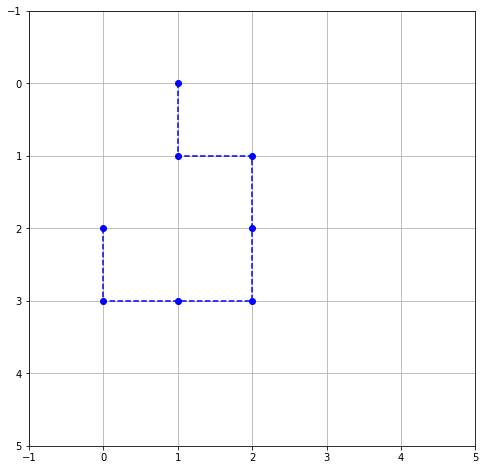

In [140]:
grid2d.state = coord2idx([2,0], 5)
traj = grid2d.Episode()
print(traj)

grid2d.PlotTrajectory(traj)
plt.gca().invert_yaxis()

In [142]:
A_coords in [(1,1), (2,3), (0,1)]

True

## 2D GridWorld with Holes

### Set up the matrices

In [348]:
gl = 5  # grid length
gs = gl*gl
n_actions = 4  # number of actions
A_coords = (0,1)
A_reward = 10.
Ap_coords = (4,1)
B_coords = (0,3)
B_reward = 5
Bp_coords = (3,3)
#C_coords = (2,2)
#C_reward = 2
holes = [(2,2),(2,3),(1,2)]
hole_reward = -7.
terminal = copy.deepcopy(holes)
terminal.append(A_coords)
terminal.append(B_coords)
movement_cost = 0.

In [349]:
def coord2idx(coords, row_length):
    return coords[0]*row_length + coords[1]
def idx2coord(idx, row_length):
    row = idx//row_length
    col = idx%row_length
    return (row,col)

In [350]:
# State Transition Probabilities: 2D Grid
# P[s,a,t] is the probability of action a taking you from state s to state t
# P[s,a,t] = p(t|a,s)
# 0==up, 1==right, 2==down, 3==left
P = np.zeros((gs,n_actions,gs))
for sr in range(gl):
    sr_offset = sr*gl
    for sc in range(gl):
        #idx = sr_offset + sc
        idx = coord2idx([sr,sc], gl)
        for a in range(4):
            img = np.zeros((gl,gl))
            if (sr,sc)==A_coords:   # A, any action
                img[Ap_coords[0],Ap_coords[1]] = 1.
            elif (sr,sc)==B_coords: # B, any action
                img[Bp_coords[0],Bp_coords[1]] = 1.
            elif (sr,sc) in holes:
                img[sr,sc] = 1.
            elif sr==0 and a==0:    # top row, up
                img[sr,sc] = 1.
            elif sr==gl-1 and a==2: # bottom row, down
                img[sr,sc] = 1.
            elif sc==0 and a==3:    # left col, left
                img[sr,sc] = 1.
            elif sc==gl-1 and a==1: # right col, right
                img[sr,sc] = 1.
            elif a==0:              # up
                img[sr-1,sc] = 1.
            elif a==1:              # right
                img[sr,sc+1] = 1.
            elif a==2:              # down
                img[sr+1,sc] = 1.
            elif a==3:              # left
                img[sr,sc-1] = 1.
            P[idx,a,:] = img.flatten()

In [351]:
# Reward Function: 2D Grid
# R[s,a] is the reward of taking action a from state s to state t
# R[s,a] = r(s,a)
R = np.zeros((gs,n_actions))
for sr in range(gl):
    sr_offset = sr*gl
    for sc in range(gl):
        #idx = sr_offset + sc
        idx = coord2idx([sr,sc], gl)
        #svec = np.zeros(gs)
        #svec[idx] = 1.
        for a in range(4):
            reward = 0.
            tvec = P[idx,a,:]
            tidx = np.argmax(tvec)
            tcoords = idx2coord(tidx, gl)
            if tcoords==A_coords:
                reward += A_reward
            elif tcoords==B_coords:
                reward += B_reward
            #elif tcoords==C_coords:
            #    reward += C_reward
            elif tcoords in holes:
                reward += hole_reward
            elif sr==0 and a==0:    # top row, up
                reward += -1.
            elif sr==gl-1 and a==2: # bottom row, down
                reward += -1.
            elif sc==0 and a==3:    # left col, left
                reward += -1.
            elif sc==gl-1 and a==1: # right col, right
                reward += -1.
            R[idx,a] = reward

### Create the MDP object

In [527]:
grid2d = MDP_2d(P, R, terminal=terminal)

In [369]:
# SARSA
for n_episodes in range(50):
    grid2d.state = np.random.randint(0,grid2d.n_states)
    grid2d.SARSA(alpha=0.1, eps=0.25)

In [457]:
# SARSA(lambda)
for n_episodes in range(50):
    grid2d.state = np.random.randint(0,grid2d.n_states)
    grid2d.SARSA_lambda(alpha=0.1, eps=0.2)

In [540]:
# Dyna-Q
for n_episodes in range(50):
    grid2d.state = np.random.randint(0,grid2d.n_states)
    grid2d.DynaQ(alpha=0.1, eps=0.2)

In [313]:
# Q-Learning
for n_episodes in range(500):
    grid2d.state = np.random.randint(0,grid2d.n_states)
    grid2d.QLearning(alpha=0.1, eps=0.1)

In [541]:
grid2d.ShowQ()

Action 0
[[-1.000e-01  0.000e+00 -1.000e-01 -9.000e-02  4.100e-02]
 [ 1.400e-02  9.657e+00 -7.000e-01  0.000e+00  7.680e-01]
 [ 0.000e+00  7.682e+00 -1.330e+00  0.000e+00  8.800e-02]
 [ 0.000e+00  4.558e+00 -3.652e+00 -2.407e+00  3.000e-03]
 [ 3.000e-03  2.092e+00  1.470e-01  3.000e-02  0.000e+00]]
Action 1
[[ 0.     0.     0.     0.     0.   ]
 [ 2.946 -1.897 -1.33   0.034 -0.26 ]
 [ 2.821 -3.987  0.    -0.7   -0.19 ]
 [ 0.     0.324  0.029  0.    -0.1  ]
 [ 0.879  0.021  0.     0.    -0.344]]
Action 2
[[ 0.481  0.     0.     0.019  0.   ]
 [ 0.418  2.233  0.    -0.7    0.   ]
 [ 0.     0.388 -1.33   0.     0.   ]
 [ 0.169  0.294  0.008  0.     0.   ]
 [-0.163  0.064 -0.1   -0.19  -0.1  ]]
Action 3
[[-0.158  0.     1.9    0.     2.855]
 [ 0.266  0.908 -0.7   -1.897  0.   ]
 [ 0.     0.078  0.    -0.7   -1.33 ]
 [-0.271  0.01   1.734  0.304  0.014]
 [-0.308  0.141  0.324  0.003  0.   ]]


In [542]:
grid2d.Pi = grid2d.OptimalPolicyFromQ()
grid2d.ShowPolicy()

Action 0
[[0.   0.25 0.   0.   0.  ]
 [0.   1.   0.   0.   1.  ]
 [0.   1.   0.   0.5  1.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   1.   0.   1.   0.5 ]]
Action 1
[[0.   0.25 0.   0.   0.  ]
 [1.   0.   0.   1.   0.  ]
 [1.   0.   0.5  0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.  ]]
Action 2
[[1.   0.25 0.   1.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.5  0.  ]
 [1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
Action 3
[[0.   0.25 1.   0.   1.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.   0.  ]
 [0.   0.   1.   1.   1.  ]
 [0.   0.   1.   0.   0.5 ]]


[18, 17, 16, 11, 6, 1]


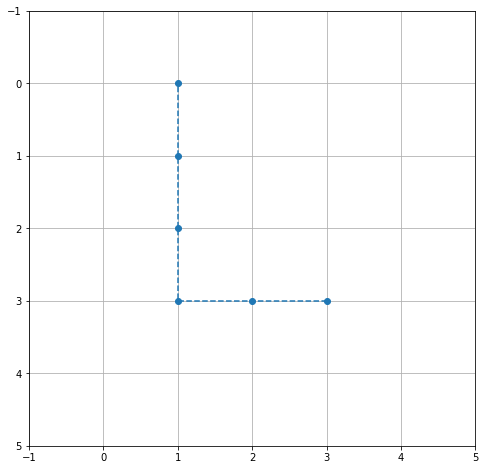

In [543]:
grid2d.state = coord2idx([3,3], 5)
traj = grid2d.Episode()
print(traj)

grid2d.PlotTrajectory(traj)
plt.gca().invert_yaxis()

In [544]:
grid2d.ShowFunction(grid2d.Q)

Action 0
[[-1.000e-01  0.000e+00 -1.000e-01 -9.000e-02  4.100e-02]
 [ 1.400e-02  9.657e+00 -7.000e-01  0.000e+00  7.680e-01]
 [ 0.000e+00  7.682e+00 -1.330e+00  0.000e+00  8.800e-02]
 [ 0.000e+00  4.558e+00 -3.652e+00 -2.407e+00  3.000e-03]
 [ 3.000e-03  2.092e+00  1.470e-01  3.000e-02  0.000e+00]]
Action 1
[[ 0.     0.     0.     0.     0.   ]
 [ 2.946 -1.897 -1.33   0.034 -0.26 ]
 [ 2.821 -3.987  0.    -0.7   -0.19 ]
 [ 0.     0.324  0.029  0.    -0.1  ]
 [ 0.879  0.021  0.     0.    -0.344]]
Action 2
[[ 0.481  0.     0.     0.019  0.   ]
 [ 0.418  2.233  0.    -0.7    0.   ]
 [ 0.     0.388 -1.33   0.     0.   ]
 [ 0.169  0.294  0.008  0.     0.   ]
 [-0.163  0.064 -0.1   -0.19  -0.1  ]]
Action 3
[[-0.158  0.     1.9    0.     2.855]
 [ 0.266  0.908 -0.7   -1.897  0.   ]
 [ 0.     0.078  0.    -0.7   -1.33 ]
 [-0.271  0.01   1.734  0.304  0.014]
 [-0.308  0.141  0.324  0.003  0.   ]]


[24, 19, 18, 17, 16, 11, 6, 1]
[[0.         0.         0.         0.         0.        ]
 [0.         0.81       0.         0.         0.        ]
 [0.         0.6561     0.         0.         0.        ]
 [0.         0.531441   0.43046721 0.34867844 0.28242954]
 [0.         0.         0.         0.         0.22876792]]


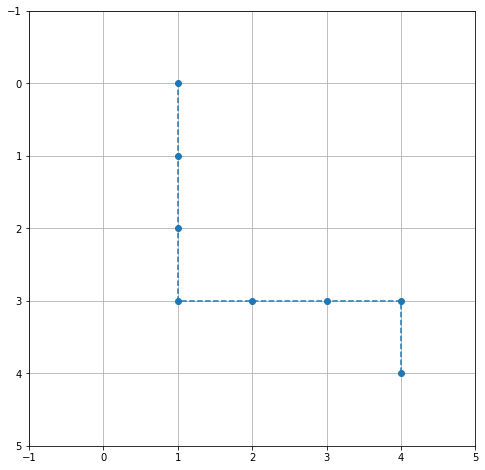

In [545]:
grid2d.state = coord2idx([4,4], 5)
traj = grid2d.SARSA_lambda(eps=0., alpha=0., trace='accumulating')
print(traj)

grid2d.PlotTrajectory(traj)
plt.gca().invert_yaxis()

print(np.reshape(np.sum(grid2d.E,axis=1),(5,5)))

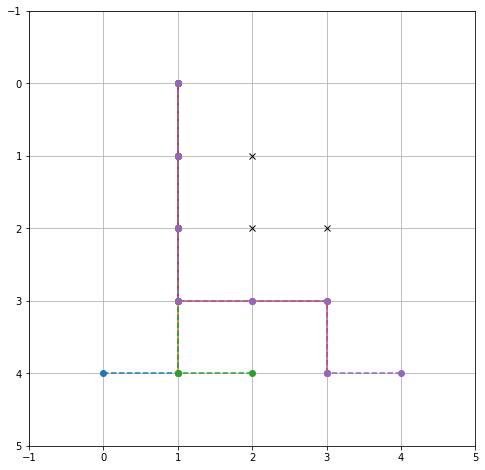

In [546]:
grid2d.state = 20
traj = grid2d.Episode()
fig = grid2d.PlotTrajectory(traj)

for s in [21,22,23,24]:
    grid2d.state = s
    traj = grid2d.Episode()
    #print(traj)

    grid2d.PlotTrajectory(traj, fig=fig)

for h in holes:
    plt.plot(h[1],h[0],'kx')
plt.gca().invert_yaxis()